# 使用QLoRA在Kaggle GPU上微调ChatGLM2

In [1]:
#安装环境

#chatglm需要
!pip install -q 'transformers==4.30.2'

In [2]:
#finetune需要
!pip install -q 'bitsandbytes==0.39.1' #提供4bit量化支持，版本限制非常重要，否则可能报错
!pip install -q datasets
!pip install -q git+https://github.com/huggingface/accelerate
!pip install  -q git+https://github.com/huggingface/peft  #使用最新版本非常重要，否则可能报错
!pip install  -q git+https://github.com/lyhue1991/torchkeras 

In [3]:
# 导入常用模块
import numpy as np
import pandas as pd 
import torch
from torch import nn 
from torch.utils.data import Dataset,DataLoader 

import warnings 
warnings.filterwarnings('ignore')



In [4]:
import torch 
print(torch.__version__)

2.0.0


In [5]:
import transformers
print(transformers.__version__)

4.30.2


In [6]:
!pip show bitsandbytes 

Name: bitsandbytes
Version: 0.39.1
Summary: k-bit optimizers and matrix multiplication routines.
Home-page: https://github.com/TimDettmers/bitsandbytes
Author: Tim Dettmers
Author-email: dettmers@cs.washington.edu
License: MIT
Location: /opt/conda/lib/python3.10/site-packages
Requires: 
Required-by: 


In [7]:
import peft 
print(peft.__version__)

0.9.1.dev0


In [8]:
import accelerate 
print(accelerate.__version__)

0.29.0.dev0


In [9]:
import torchkeras 
print(torchkeras.__version__)

3.9.7


## 〇，预训练模型


#### ChatGLM2-6b

chatglm2是 Chat General Language Model Version2的缩写，翻译成中文就是，通用语言模型(GLM)的聊天(Chat)优化版本。

6b的意思是6个billion,也就是60亿参数的大模型。

整个名字中最核心的概念有两个：

第一个是LM：语言模型。语言模型本质上只能做一件事情，那就是判断一段话像不像人话。为了实现这个功能，一般用几百上千T的文本数据对语言模型进行Pretrain。完成Pretrain之后，语言模型就可以做文字接龙游戏了。也就是给一段话的上半部分，它可以按照最像人话的方式进行文本生成，输出下半部分。

例如，你给它上半部分:"世界上最高的山峰是什么？" 它可能会生成下半部分"世界上最长的河流是什么？"，也可能生成下半部分为"珠穆朗玛峰。" 

这两种文字接龙的方式都是合理的，这两段话在它的训练数据即各种互联网语料中都是常见的。但是显然，只有"珠穆朗玛峰。"这个结果才是属于符合人类偏好的。为了让LM按照人类偏好进行接龙，我们需要在预训练的基础上进行聊天优化。

第二个是Chat: 聊天优化。聊天优化只有一个目的，那就是偏好对齐。本质上就是让语言模型能够按照符合人类对话偏好的方式去进行文字接龙。这里的Chat和ChatGPT的Chat是相同的意思，就是语言模型不仅仅是会说人话的，还得会聊天。

这里的会聊天通常会用3H来衡量，那就是 helpful, honest, harmless。第一个helpful要求模型明白用户意图不能答非所问，第二个honest要求模型不能假话连篇满嘴跑火车也就是要避免幻觉。第三个harmless就是说模型要避免道德风险不能提供对人类社会有危害如黄色暴力等内容。

以人的视角来看，如果有个朋友跟我们聊天，他能够满足helpful, honest, harmless这3H的话，真的是情商非常高，非常会聊天了。

那么，如何训练出这样一个情商高会聊天的大语言模型ChatGLM呢？为了训练一个ChatGLM，我们要走4个训练步骤。

其中第1个步骤是为了让它懂人话(会接龙)，第2到4个步骤是让它懂聊天(会聊天)，一般把第3~4个步骤合起来叫做RLHF(ReinForce Learning From Human FeedBack)。

0，PT (预训练)。 Pretrain. 用海量清洗过的无标注普通文本数据训练模型的文字接龙能力。

1，SFT(指令微调)。Supervised FineTune. 用数十至数百万清洗过的对话数据进行初步的人类偏好对齐。

2，RM(奖励建模)。 ReWard Model. 随机生成数十至数百万问题让模型回答，人工判断该回答对人类偏好的符合程度，进行打分。使用该份人工打分数据训练一个奖励模型Reward Model，奖励模型可以对任何问题的回答按照人类偏好近似打分。

3，RL(强化学习)。 ReinForce Learning. 随机生成数千万数亿的问题让模型回答，根据奖励模型的反馈信号朝着人类偏好对齐的方向上进一步优化模型。



### 部署模型ChatGLM2-6b模型

In [10]:
from transformers import AutoTokenizer,AutoConfig, AutoModel, BitsAndBytesConfig

#为了能够在kaggle中使用，需要设置 bnb_config
model_name_or_path = 'THUDM/chatglm2-6b' 
bnb_config=BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_compute_dtype=torch.float16,
            bnb_4bit_use_double_quant=True, #QLoRA 设计的 Double Quantization
            bnb_4bit_quant_type="nf4", #QLoRA 设计的 Normal Float 4 量化数据类型
            llm_int8_threshold=6.0,
            llm_int8_has_fp16_weight=False,
        )
tokenizer = AutoTokenizer.from_pretrained(
    model_name_or_path, trust_remote_code=True) # cache_dir='./' 缓存到当前工作路径

model = AutoModel.from_pretrained(model_name_or_path,
                quantization_config=bnb_config,
                trust_remote_code=True)  # cache_dir='./'

tokenizer_config.json:   0%|          | 0.00/244 [00:00<?, ?B/s]

tokenization_chatglm.py:   0%|          | 0.00/10.1k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/THUDM/chatglm2-6b:
- tokenization_chatglm.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


tokenizer.model:   0%|          | 0.00/1.02M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.32k [00:00<?, ?B/s]

configuration_chatglm.py:   0%|          | 0.00/2.33k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/THUDM/chatglm2-6b:
- configuration_chatglm.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_chatglm.py:   0%|          | 0.00/54.9k [00:00<?, ?B/s]

quantization.py:   0%|          | 0.00/14.7k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/THUDM/chatglm2-6b:
- quantization.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/THUDM/chatglm2-6b:
- modeling_chatglm.py
- quantization.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


pytorch_model.bin.index.json:   0%|          | 0.00/20.4k [00:00<?, ?B/s]

pytorch_model-00001-of-00007.bin:   0%|          | 0.00/1.83G [00:00<?, ?B/s]

pytorch_model-00002-of-00007.bin:   0%|          | 0.00/1.97G [00:00<?, ?B/s]

pytorch_model-00003-of-00007.bin:   0%|          | 0.00/1.93G [00:00<?, ?B/s]

pytorch_model-00004-of-00007.bin:   0%|          | 0.00/1.82G [00:00<?, ?B/s]

pytorch_model-00005-of-00007.bin:   0%|          | 0.00/1.97G [00:00<?, ?B/s]

pytorch_model-00006-of-00007.bin:   0%|          | 0.00/1.93G [00:00<?, ?B/s]

pytorch_model-00007-of-00007.bin:   0%|          | 0.00/1.05G [00:00<?, ?B/s]


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /opt/conda/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda118_nocublaslt.so
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so.11.0
CUDA SETUP: Highest compute capability among GPUs detected: 6.0
CUDA SETUP: Detected CUDA version 118
CUDA SETUP: Loading binary /opt/conda/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda118_nocublaslt.so...


Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

#### 接口测试

In [11]:
#generate 文字接龙接口
text = '世界上最高的山峰是'
inputs = tokenizer(text)
inputs = {k:torch.tensor([v]) for k,v in inputs.items()}
outputs = model.generate(**inputs,max_new_tokens=64,repetition_penalty=1.1)
tokenizer.batch_decode(outputs) 

['世界上最高的山峰是珠穆朗玛峰，它的海拔高度为8848米。 根据题目所给的信息，珠穆朗玛峰的海拔高度为8848米。']

In [12]:
#chat 聊天接口
response,history= model.chat(tokenizer,query='世界上最高的山峰是什么？',history=[])
print(response)

世界上最高的山峰是珠穆朗玛峰(Mount Everest),位于喜马拉雅山脉,海拔高度8,848.86米(29,031.69英尺)。珠穆朗玛峰是世界上最著名和最具挑战性的登山目标之一,吸引了许多登山者前来挑战。


In [13]:
#stream_chat 流聊天接口(打字机风格)
result = model.stream_chat(tokenizer,query='世界上最高的山峰是什么？',history=[])
for response,history in result:
    print(response,end='\r')

In [14]:
#stream_chat 流聊天接口(打字机风格)
result = model.stream_chat(tokenizer,query='你知道友人A吗？',history=[])
for response,history in result:
    print(response,end='\r')

## 一，准备数据

### 1，构造数据

In [15]:
#定义一条知识样本~

keyword = '友人A'

description = '''友人A（LZ）是一位大四学生，目前就读智能科学与技术专业。
23年年末，与于教授进行毕业设计双选，选择了  基于ChatGLM-6b的多轮对话生成  课题。
现已成功完成该课题。'''

#对prompt使用一些简单的数据增强的方法，以便更好地收敛。
def get_prompt_list(keyword):
    return [f'{keyword}', 
            f'你知道{keyword}吗?',
            f'{keyword}是什么？',
            f'介绍一下{keyword}',
            f'你听过{keyword}吗?',
            f'啥是{keyword}？',
            f'{keyword}是何物？',
            f'何为{keyword}？',
           ]

data =[{'prompt':x,'response':description} for x in get_prompt_list(keyword) ]
dfdata = pd.DataFrame(data)
display(dfdata) 


,prompt,response
0,友人A,友人A（LZ）是一位大四学生，目前就读智能科学与技术专业。\n23年年末，与于教授进行毕业设...
1,你知道友人A吗?,友人A（LZ）是一位大四学生，目前就读智能科学与技术专业。\n23年年末，与于教授进行毕业设...
2,友人A是什么？,友人A（LZ）是一位大四学生，目前就读智能科学与技术专业。\n23年年末，与于教授进行毕业设...
3,介绍一下友人A,友人A（LZ）是一位大四学生，目前就读智能科学与技术专业。\n23年年末，与于教授进行毕业设...
4,你听过友人A吗?,友人A（LZ）是一位大四学生，目前就读智能科学与技术专业。\n23年年末，与于教授进行毕业设...
5,啥是友人A？,友人A（LZ）是一位大四学生，目前就读智能科学与技术专业。\n23年年末，与于教授进行毕业设...
6,友人A是何物？,友人A（LZ）是一位大四学生，目前就读智能科学与技术专业。\n23年年末，与于教授进行毕业设...
7,何为友人A？,友人A（LZ）是一位大四学生，目前就读智能科学与技术专业。\n23年年末，与于教授进行毕业设...


In [16]:
from torch.utils.data import Dataset,DataLoader
class MyDataset(Dataset):
    def __init__(self,df,tokenizer,
                 prompt_col = 'prompt',
                 response_col = 'response',
                 history_col = 'history',
                 max_context_length = 1024,
                 max_target_length = 1024
                ):
        super().__init__()
        self.__dict__.update(locals())
        
    def __len__(self):
        return len(self.df)

    
    def get(self,index):
        data = dict(self.df.iloc[index])
        example = {}
        #context根据prompt和history以及
        example['context'] = self.tokenizer.build_prompt(
            query = data[self.prompt_col],
            history = data.get(self.history_col,None))
        example['target'] = data[self.response_col]
        return example 
    
    def __getitem__(self,index):
        example = self.get(index)
        a_ids = self.tokenizer.encode(text=example['context'], 
                add_special_tokens=True, truncation=True,
                max_length=self.max_context_length)
        b_ids = self.tokenizer.encode(text=example['target'], 
                                      add_special_tokens=False, truncation=True,
                                     max_length=self.max_target_length)
        input_ids = a_ids + b_ids + [tokenizer.eos_token_id]
        
        #专注于 b_ids和 最后的eos_token_id的学习
        labels = [-100]*len(a_ids)+b_ids+[tokenizer.eos_token_id]
        return {'input_ids':input_ids,'labels':labels}
    

In [17]:
#训练集和验证集完全一样
ds_train = ds_val = MyDataset(dfdata,tokenizer)
print(ds_train[0]) 

{'input_ids': [64790, 64792, 790, 30951, 517, 30910, 30939, 30996, 13, 13, 54761, 31211, 47454, 30938, 13, 13, 55437, 31211, 30910, 47454, 30938, 31301, 30957, 31020, 31300, 36853, 54539, 54795, 31678, 31123, 31753, 39181, 32093, 47439, 31720, 31155, 13, 30943, 30966, 54540, 39636, 31123, 54619, 54579, 32037, 31636, 32121, 31735, 55137, 54878, 31123, 35924, 265, 33053, 30942, 1960, 10461, 30944, 30941, 30978, 30931, 36105, 55571, 34580, 36454, 265, 34487, 31155, 13, 41983, 31861, 31785, 54960, 34487, 31155, 2], 'labels': [-100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, 30910, 47454, 30938, 31301, 30957, 31020, 31300, 36853, 54539, 54795, 31678, 31123, 31753, 39181, 32093, 47439, 31720, 31155, 13, 30943, 30966, 54540, 39636, 31123, 54619, 54579, 32037, 31636, 32121, 31735, 55137, 54878, 31123, 35924, 265, 33053, 30942, 1960, 10461, 30944, 30941, 30978, 30931, 36105, 55571, 34580, 36454, 265, 34487, 31155, 13, 41983, 31861, 3178

### 2，构建管道

In [18]:
from transformers import DataCollatorForSeq2Seq
data_collator = DataCollatorForSeq2Seq(
    tokenizer,
    model=None,
    label_pad_token_id=-100,
    pad_to_multiple_of=None,
    padding=True
)

dl_train = DataLoader(ds_train,batch_size = 4,
                      num_workers = 2, shuffle = True, collate_fn = data_collator 
                     )
dl_val = DataLoader(ds_val,batch_size = 4,
                      num_workers = 2, shuffle = False, collate_fn = data_collator 
                     )


In [19]:
for batch in dl_train:
    break

In [20]:
batch.keys() 

dict_keys(['input_ids', 'labels', 'attention_mask', 'position_ids'])

In [21]:
batch['input_ids'].shape 

torch.Size([4, 80])

In [22]:
print(len(dl_train))

2


## 二，定义模型

使用QLoRA算法来微调ChatGLM2模型，以便给模型注入和数据集 torchkeras相关的知识。


1，LoRA

LoRA是一种能够相比全参微调可以大幅节约训练时间和显存，同时微调效果基本可以相当于全参微调的算法。

其全称叫做 Low Rank Adaption，也就是低秩适配方法，由微软2021年提出的。

LoRA的思想非常简单，有些像SVD奇异值分解的想法。

保持预训练好的参数矩阵不变，在它的旁边学习两个小的低秩矩阵，用它们的乘积来作为大的参数矩阵需要改变的增量。

用公式表示如下:

$$W = W_0 + \Delta W = W_0 + B A$$

$$shape(W_0)=(m,n), shape(B) = (m,r), shape(A) = (r,n), r<<min(m,n)$$ 

在初始化的时候，$B$矩阵初始化为0，$A$矩阵随机初始化，这样开始的时候，增量$\Delta W$是零矩阵，不影响推理结果。


2，QLoRA

QLoRA是Quantized LoRA的简称，相比与LoRA能够进一步节约显存占用，并提升微调效果。

QLoRA在LoRA的基础上主要有3处创新。

a，NF4数据类型：提出了一种叫做NF4(4-bit NormalFloat)的量化数据类型。这种精心设计的量化数据类型在拥有很高的压缩率的情况下(大概是fp16的1/4)还能够保持非常高的精度。

b，Double Quantization方法：对NF4数据类型中使用的一些常量参数也做量化，进一步减少存储占用。

c，Paged Optimizers技术：这种技术使用了NVIDIA统一内存的特性，实现了CPU和GPU之间自动的页面转换，在GPU内存不足的情况下自动将优化器状态转移到CPU内存。


使用QLoRA算法需要结合bitsandbytes库和peft库。

为什么QLoRA相比LoRA还能够提升效果呢？主要是因为QLoRA由于节约了大量存储空间，所以可以对更多的权重矩阵进行微调。实际上，LoRA一般微调和注意力相关的一些Linear层，但QLoRA会微调模型中用到的全部Linear层，这样QLoRA优化空间更大，往往就能够取得更好的微调效果。


In [23]:
from peft import get_peft_config, get_peft_model, TaskType

model.supports_gradient_checkpointing = True  #
model.gradient_checkpointing_enable()
model.enable_input_require_grads()

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!



In [24]:
from peft import prepare_model_for_kbit_training 
model = prepare_model_for_kbit_training(model) #预处理量化模型以适配LoRA


In [25]:
import bitsandbytes as bnb 
def find_all_linear_names(model):
    """
    找出所有全连接层，为所有全连接添加低秩adapter
    """
    cls = bnb.nn.Linear4bit
    lora_module_names = set()
    for name, module in model.named_modules():
        if isinstance(module, cls):
            names = name.split('.')
            lora_module_names.add(names[0] if len(names) == 1 else names[-1])

    if 'lm_head' in lora_module_names:  # needed for 16-bit
        lora_module_names.remove('lm_head')
    return list(lora_module_names)

lora_modules = find_all_linear_names(model)

print(lora_modules)


['dense', 'dense_h_to_4h', 'query_key_value', 'dense_4h_to_h']


In [26]:
from peft import LoraConfig

peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM, inference_mode=False,
    r=8,
    lora_alpha=32, lora_dropout=0.1,
    target_modules= lora_modules 
)


peft_model = get_peft_model(model, peft_config)

peft_model.is_parallelizable = True
peft_model.model_parallel = True
peft_model.print_trainable_parameters()


trainable params: 14,823,424 || all params: 6,258,407,424 || trainable%: 0.23685616796302714


In [27]:
# 注意到LoRA算法 B矩阵的初始权重为0，所以训练前peft_model的输出等价于预训练模型model的输出
for name,para in peft_model.named_parameters():
    if '.1.' in name:
        break 
    if 'lora' in name.lower():
        print(name+':')
        print('shape = ',list(para.shape),'\t','sum = ',para.sum().item())
        print('\n')

base_model.model.transformer.encoder.layers.0.self_attention.query_key_value.lora_A.default.weight:
shape =  [8, 4096] 	 sum =  -1.0860049724578857


base_model.model.transformer.encoder.layers.0.self_attention.query_key_value.lora_B.default.weight:
shape =  [4608, 8] 	 sum =  0.0


base_model.model.transformer.encoder.layers.0.self_attention.dense.lora_A.default.weight:
shape =  [8, 4096] 	 sum =  1.9512320756912231


base_model.model.transformer.encoder.layers.0.self_attention.dense.lora_B.default.weight:
shape =  [4096, 8] 	 sum =  0.0


base_model.model.transformer.encoder.layers.0.mlp.dense_h_to_4h.lora_A.default.weight:
shape =  [8, 4096] 	 sum =  -0.7549108862876892


base_model.model.transformer.encoder.layers.0.mlp.dense_h_to_4h.lora_B.default.weight:
shape =  [27392, 8] 	 sum =  0.0


base_model.model.transformer.encoder.layers.0.mlp.dense_4h_to_h.lora_A.default.weight:
shape =  [8, 13696] 	 sum =  0.1774677038192749


base_model.model.transformer.encoder.layers.0.mlp.dense_4

In [28]:
peft_model.train();
out = peft_model(**batch)


In [29]:
out.loss 

tensor(4.6725, grad_fn=<ToCopyBackward0>)

## 三，训练模型

为了更加高效地保存和加载参数，我们覆盖了KerasModel中的load_ckpt和save_ckpt方法，

仅仅保存和加载可训练lora权重，这样可以避免加载和保存全部模型权重造成的存储问题。


In [30]:
from torchkeras import KerasModel 
from accelerate import Accelerator 

class StepRunner:
    def __init__(self, net, loss_fn, accelerator=None, stage = "train", metrics_dict = None, 
                 optimizer = None, lr_scheduler = None
                 ):
        self.net,self.loss_fn,self.metrics_dict,self.stage = net,loss_fn,metrics_dict,stage
        self.optimizer,self.lr_scheduler = optimizer,lr_scheduler
        self.accelerator = accelerator if accelerator is not None else Accelerator() 
        if self.stage=='train':
            self.net.train() 
        else:
            self.net.eval()
    
    def __call__(self, batch):
        
        #loss
        with self.accelerator.autocast():
            loss = self.net(**batch).loss

        #backward()
        if self.optimizer is not None and self.stage=="train":
            self.accelerator.backward(loss)
            if self.accelerator.sync_gradients:
                self.accelerator.clip_grad_norm_(self.net.parameters(), 1.0)
            self.optimizer.step()
            if self.lr_scheduler is not None:
                self.lr_scheduler.step()
            self.optimizer.zero_grad()
            
        all_loss = self.accelerator.gather(loss).sum()
        
        #losses (or plain metrics that can be averaged)
        step_losses = {self.stage+"_loss":all_loss.item()}
        
        #metrics (stateful metrics)
        step_metrics = {}
        
        if self.stage=="train":
            if self.optimizer is not None:
                step_metrics['lr'] = self.optimizer.state_dict()['param_groups'][0]['lr']
            else:
                step_metrics['lr'] = 0.0
        return step_losses,step_metrics
    
KerasModel.StepRunner = StepRunner 


#仅仅保存lora可训练参数
def save_ckpt(self, ckpt_path='checkpoint', accelerator = None):
    unwrap_net = accelerator.unwrap_model(self.net)
    unwrap_net.save_pretrained(ckpt_path)
    
def load_ckpt(self, ckpt_path='checkpoint'):
    import os
    self.net.load_state_dict(
        torch.load(os.path.join(ckpt_path,'adapter_model.bin')),strict =False)
    self.from_scratch = False
    
KerasModel.save_ckpt = save_ckpt 
KerasModel.load_ckpt = load_ckpt 


In [31]:
# 此处设置is_paged=True，即使用Paged Optimizer，减少训练过程中Cuda OOM的风险。
optimizer = bnb.optim.adamw.AdamW(peft_model.parameters(),
                                  lr=5e-05,is_paged=True)  

keras_model = KerasModel(peft_model,loss_fn = None,
        optimizer=optimizer) 

ckpt_path = 'chatglm2_qlora'


<<<<<< ⚡️ cuda is used >>>>>>


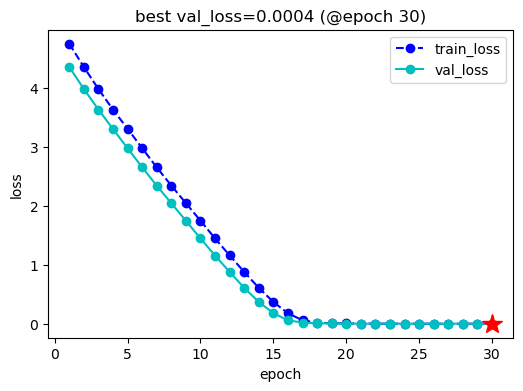

FileNotFoundError: [Errno 2] No such file or directory: 'chatglm2_qlora/adapter_model.bin'

In [32]:
dfhistory = keras_model.fit(train_data = dl_train,
                val_data = dl_val,
                epochs=30,
                patience=4,
                monitor='val_loss',
                mode='min',
                ckpt_path = ckpt_path,
                gradient_accumulation_steps = 2
               )

#### 上方代码

由于本代码在kaggle环境下运行，磁盘容量仅有19.5G，之前部署仅部署在了缓存区，所以显示路径错误。
但并不影响小模型的生成，之后在cpu环境下融合即可得到完整模型。

In [33]:
!du -s -h chatglm2_qlora 

57M	chatglm2_qlora


## 四，上传模型

为了使用模型，需要合并LoRA权重到预训练模型权重中。

由于LoRA权重是非量化类型(float32)的，要求加载的预训练模型权重非量化类型(float32或fp16)。

不使用量化的话，加载模型权重需要较高的内存，但在GPU模式下，Kaggle的机器只有13个G的内存。

直接加载预训练模型权重会报OOM的错误。所以我们需要切换到CPU模式下(30G内存)。

合并且保存权重后，再切换成GPU模式。


In [1]:
#安装环境(为避免GPU下OOM，切换成CPU模式后重新安装环境)

!pip install  -q git+https://github.com/huggingface/peft  #使用最新版本非常重要，否则可能报错

In [2]:
# 导入常用模块
import numpy as np
import pandas as pd 
import torch
from torch import nn 
from torch.utils.data import Dataset,DataLoader 

import warnings 
warnings.filterwarnings('ignore')

#务必将notebook切换成CPU模式，否则会报OOM错误
#print(torch.cuda.is_available())

In [3]:
from transformers import AutoTokenizer, AutoModel

model_name_or_path = "THUDM/chatglm2-6b"

tokenizer = AutoTokenizer.from_pretrained(
    model_name_or_path, trust_remote_code=True) # cache_dir='./' 缓存到当前工作路径

model = AutoModel.from_pretrained(model_name_or_path,
                trust_remote_code=True) # cache_dir='./' 


tokenizer_config.json:   0%|          | 0.00/244 [00:00<?, ?B/s]

tokenization_chatglm.py:   0%|          | 0.00/10.1k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/THUDM/chatglm2-6b:
- tokenization_chatglm.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


tokenizer.model:   0%|          | 0.00/1.02M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.32k [00:00<?, ?B/s]

configuration_chatglm.py:   0%|          | 0.00/2.33k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/THUDM/chatglm2-6b:
- configuration_chatglm.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_chatglm.py:   0%|          | 0.00/54.9k [00:00<?, ?B/s]

quantization.py:   0%|          | 0.00/14.7k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/THUDM/chatglm2-6b:
- quantization.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/THUDM/chatglm2-6b:
- modeling_chatglm.py
- quantization.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


pytorch_model.bin.index.json:   0%|          | 0.00/20.4k [00:00<?, ?B/s]

pytorch_model-00001-of-00007.bin:   0%|          | 0.00/1.83G [00:00<?, ?B/s]

pytorch_model-00002-of-00007.bin:   0%|          | 0.00/1.97G [00:00<?, ?B/s]

pytorch_model-00003-of-00007.bin:   0%|          | 0.00/1.93G [00:00<?, ?B/s]

pytorch_model-00004-of-00007.bin:   0%|          | 0.00/1.82G [00:00<?, ?B/s]

pytorch_model-00005-of-00007.bin:   0%|          | 0.00/1.97G [00:00<?, ?B/s]

pytorch_model-00006-of-00007.bin:   0%|          | 0.00/1.93G [00:00<?, ?B/s]

pytorch_model-00007-of-00007.bin:   0%|          | 0.00/1.05G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

### 加载预训练模型

In [4]:
from peft import PeftModel
ckpt_path = 'chatglm2_qlora/'
peft_loaded = PeftModel.from_pretrained(model,ckpt_path)

In [5]:
model_new = peft_loaded.merge_and_unload() #合并lora权重

### 保存合并后的模型

In [6]:
save_path = "chatglm2-6b-torchkeras"
model_new.save_pretrained(save_path, max_shard_size='2GB')

In [7]:
tokenizer.save_pretrained(save_path) 

('chatglm2-6b-torchkeras/tokenizer_config.json',
 'chatglm2-6b-torchkeras/special_tokens_map.json',
 'chatglm2-6b-torchkeras/tokenizer.model',
 'chatglm2-6b-torchkeras/added_tokens.json')

### 将模型上传至huggingface.co网站，本人的模型库中。

In [8]:
#从chatglm2-6b官方仓库下载其他的依赖文件，忽略权重
!GIT_LFS_SKIP_SMUDGE=1 git clone https://huggingface.co/THUDM/chatglm2-6b/

Cloning into 'chatglm2-6b'...
remote: Enumerating objects: 186, done.
remote: Counting objects: 100% (186/186), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 186 (delta 103), reused 186 (delta 103), pack-reused 0
Receiving objects: 100% (186/186), 1.92 MiB | 7.91 MiB/s, done.
Resolving deltas: 100% (103/103), done.


In [9]:
!cp  chatglm2-6b/*.py {save_path}

In [10]:
!ls {save_path}

config.json			  pytorch_model-00006-of-00007.bin
configuration_chatglm.py	  pytorch_model-00007-of-00007.bin
generation_config.json		  pytorch_model.bin.index.json
modeling_chatglm.py		  quantization.py
pytorch_model-00001-of-00007.bin  special_tokens_map.json
pytorch_model-00002-of-00007.bin  tokenization_chatglm.py
pytorch_model-00003-of-00007.bin  tokenizer.model
pytorch_model-00004-of-00007.bin  tokenizer_config.json
pytorch_model-00005-of-00007.bin


In [11]:
from huggingface_hub import login
login() #需要注册一个huggingface账户，在个人页面setting那里创建一个有write权限的access token

In [12]:
from huggingface_hub import HfApi
api = HfApi()

In [14]:
#上传模型可能需要等待10分钟左右~
repo_id = "eheliu/chatglm2-6b-torchkeras"
api.upload_folder(
    folder_path=save_path,
    repo_id=repo_id,
    repo_type="model", #space, model, datasets
)

pytorch_model-00001-of-00007.bin:   0%|          | 0.00/1.83G [00:00<?, ?B/s]

pytorch_model-00002-of-00007.bin:   0%|          | 0.00/1.97G [00:00<?, ?B/s]

pytorch_model-00003-of-00007.bin:   0%|          | 0.00/1.93G [00:00<?, ?B/s]

pytorch_model-00005-of-00007.bin:   0%|          | 0.00/1.97G [00:00<?, ?B/s]

pytorch_model-00004-of-00007.bin:   0%|          | 0.00/1.82G [00:00<?, ?B/s]

Upload 8 LFS files:   0%|          | 0/8 [00:00<?, ?it/s]

pytorch_model-00006-of-00007.bin:   0%|          | 0.00/1.93G [00:00<?, ?B/s]

pytorch_model-00007-of-00007.bin:   0%|          | 0.00/1.05G [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/1.02M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/eheliu/chatglm2-6b-torchkeras/commit/4cf24268f623a485e5e52b77c96e5d033589533e', commit_message='Upload folder using huggingface_hub', commit_description='', oid='4cf24268f623a485e5e52b77c96e5d033589533e', pr_url=None, pr_revision=None, pr_num=None)

In [15]:
#上传成功后可以删除本地模型
!rm  -rf chatglm2-6b-torchkeras

## 五，使用模型

我们重新切换成GPU环境，直接从huggingface导入刚才我们训练好的 'lyhue1991/chatglm2-6b-torchkeras'模型进行测试。就好像导入chatglm2-6b官方模型一样。

In [1]:
#安装环境

#chatglm需要
!pip install -q 'transformers==4.30.2'

#finetune需要
!pip install -q 'bitsandbytes==0.39.1' #提供4bit量化支持，版本限制非常重要，否则可能报错
!pip install -q datasets
!pip install -q git+https://github.com/huggingface/accelerate
!pip install  -q git+https://github.com/huggingface/peft  #使用最新版本非常重要，否则可能报错
!pip install  -q git+https://github.com/lyhue1991/torchkeras 

In [2]:
# 导入常用模块
import numpy as np
import pandas as pd 
import torch
from torch import nn 
from torch.utils.data import Dataset,DataLoader 

import warnings 
warnings.filterwarnings('ignore')


In [3]:
from transformers import AutoTokenizer,AutoConfig, AutoModel, BitsAndBytesConfig

#为了能够在kaggle中使用，需要设置 bnb_config
model_name_or_path = 'eheliu/chatglm2-6b-torchkeras'
config = AutoConfig.from_pretrained(model_name_or_path, trust_remote_code=True)
bnb_config=BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_compute_dtype=torch.float16,
            bnb_4bit_use_double_quant=True, #QLoRA 设计的 Double Quantization
            bnb_4bit_quant_type="nf4", #QLoRA 设计的 Normal Float 4 量化数据类型
            llm_int8_threshold=6.0,
            llm_int8_has_fp16_weight=False,
        )
tokenizer = AutoTokenizer.from_pretrained(
    'THUDM/chatglm2-6b' , trust_remote_code=True) # cache_dir='./' 缓存到当前工作路径

model = AutoModel.from_pretrained(model_name_or_path,
                config=config,
                quantization_config=bnb_config,
                trust_remote_code=True)  # cache_dir='./'


config.json:   0%|          | 0.00/1.56k [00:00<?, ?B/s]

configuration_chatglm.py:   0%|          | 0.00/2.33k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/THUDM/chatglm2-6b:
- configuration_chatglm.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


tokenizer_config.json:   0%|          | 0.00/244 [00:00<?, ?B/s]

tokenization_chatglm.py:   0%|          | 0.00/10.1k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/THUDM/chatglm2-6b:
- tokenization_chatglm.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


tokenizer.model:   0%|          | 0.00/1.02M [00:00<?, ?B/s]

modeling_chatglm.py:   0%|          | 0.00/54.9k [00:00<?, ?B/s]

quantization.py:   0%|          | 0.00/14.7k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/THUDM/chatglm2-6b:
- quantization.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/THUDM/chatglm2-6b:
- modeling_chatglm.py
- quantization.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


pytorch_model.bin.index.json:   0%|          | 0.00/20.4k [00:00<?, ?B/s]

pytorch_model-00001-of-00007.bin:   0%|          | 0.00/1.83G [00:00<?, ?B/s]

pytorch_model-00002-of-00007.bin:   0%|          | 0.00/1.97G [00:00<?, ?B/s]

pytorch_model-00003-of-00007.bin:   0%|          | 0.00/1.93G [00:00<?, ?B/s]

pytorch_model-00004-of-00007.bin:   0%|          | 0.00/1.82G [00:00<?, ?B/s]

pytorch_model-00005-of-00007.bin:   0%|          | 0.00/1.97G [00:00<?, ?B/s]

pytorch_model-00006-of-00007.bin:   0%|          | 0.00/1.93G [00:00<?, ?B/s]

pytorch_model-00007-of-00007.bin:   0%|          | 0.00/1.05G [00:00<?, ?B/s]


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /opt/conda/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda117_nocublaslt.so
CUDA SETUP: CUDA runtime path found: /opt/conda/lib/libcudart.so.11.0
CUDA SETUP: Highest compute capability among GPUs detected: 6.0
CUDA SETUP: Detected CUDA version 117
CUDA SETUP: Loading binary /opt/conda/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda117_nocublaslt.so...


Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

In [10]:
#chat 聊天接口
response,history= model.chat(tokenizer,query='你知道友人A吗？',history=[])
print(response)

友人A（LZ）是一位大四学生，目前就读智能科学与技术专业。
23年年末，与于教授进行毕业设计双选，选择了  基于ChatGLM-6b的多轮对话生成  课题。
现已成功完成该课题。


In [11]:
#stream_chat 流聊天接口(打字机风格)
result = model.stream_chat(tokenizer,query='来称赞一下友人Ａ？',history=[])
for response,history in result:
    print(response,end='\r')

In [14]:
#chat 聊天接口
response,history= model.chat(tokenizer,query='用委婉小诗方式称赞友人A',history=[])
print(response)

友人A，才子俊秀，
德艺俱佳，令人敬仰。
舌笔生花，文采飞扬，
笃学敏思，不负青春。

心怀天下，关注社会，
热忱公益，贡献良多。
宽厚待人，严于律己，
真乃大家风范。

愿友A继续努力，
成就更多的人。
以梦为马，不负青春，
共赴人生的辉煌。


In [15]:
#chat 聊天接口
response,history= model.chat(tokenizer,query='谢谢你的称赞，本此多轮对话结束了，再见',history=[])
print(response)

好的,再见!欢迎你随时回来和我交流。
